<a href="https://colab.research.google.com/github/hi-myn/Otimiza-o-Modelo/blob/main/ConfusionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta1 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta1


In [2]:
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
tf.__version__

'2.18.0'

In [4]:
%load_ext tensorboard

In [5]:
logdir = 'log'

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images/255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model = models.Sequential()
#camadas convulacionais
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Camadas densas
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #acurácia

model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 46ms/step - accuracy: 0.8950 - loss: 0.3387 - val_accuracy: 0.9835 - val_loss: 0.0505
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 37ms/step - accuracy: 0.9847 - loss: 0.0499 - val_accuracy: 0.9815 - val_loss: 0.0563
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - accuracy: 0.9897 - loss: 0.0339 - val_accuracy: 0.9895 - val_loss: 0.0319
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9922 - loss: 0.0234 - val_accuracy: 0.9915 - val_loss: 0.0278
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.9922 - val_loss: 0.0284


In [10]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [11]:
classes=[0,1,2,3,4,5,6,7,8,9]

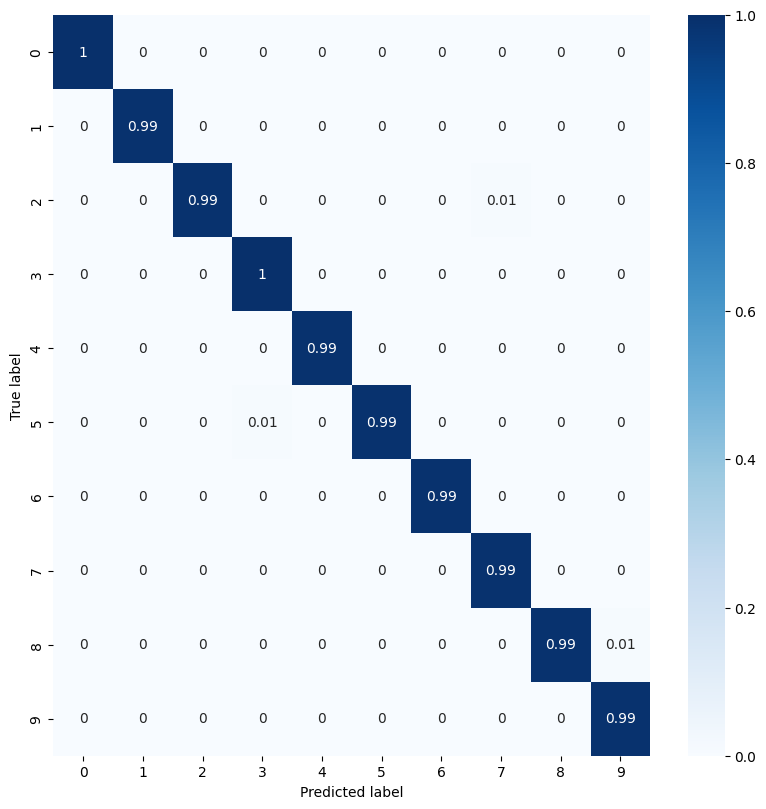

In [12]:
con_mat = tf.math.confusion_matrix(labels=y_true,predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes,
                          columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Sensibilidade (Recall): 0.9922338642595145
Acurácia: 0.9922
F-score: 0.9921936941584916


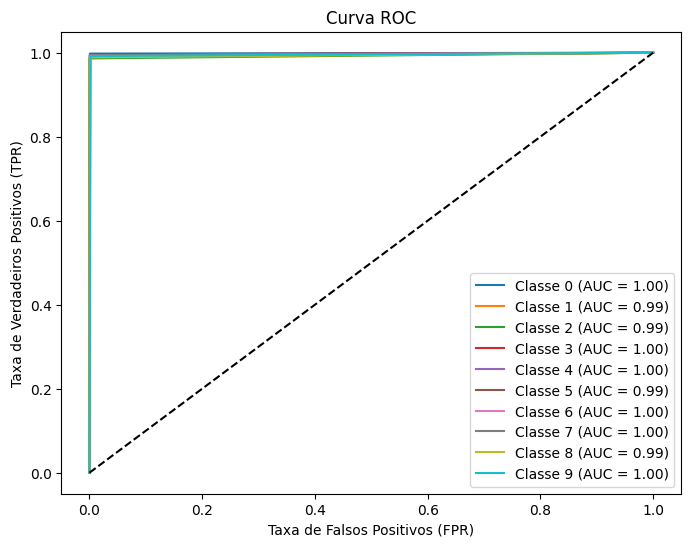

In [13]:
# Sensibilidade (Recall)
recall = recall_score(y_true, y_pred, average='macro')
print(f"Sensibilidade (Recall): {recall}")

# Acurácia
accuracy = accuracy_score(y_true, y_pred)
print(f"Acurácia: {accuracy}")

# F-score
f_score = f1_score(y_true, y_pred, average='macro')
print(f"F-score: {f_score}")

# Curva ROC
# Binarize as labels para calcular a curva ROC para cada classe
y_true_bin = label_binarize(y_true, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_true_bin.shape[1]

# Calcular a curva ROC e a área sob a curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()